<a href="https://colab.research.google.com/github/aliakbarbadri/persian-poetry-creator/blob/master/char.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time

# Load the data

In [2]:
url = "https://raw.githubusercontent.com/aliakbarbadri/persian-poetry-creator/master/shahname2.txt"
filepath = keras.utils.get_file("shahname2.txt", url) 
corpus = open(filepath, 'rb').read().decode(encoding='utf-8')
corpus = corpus.replace("\t"," \t ").replace("\n", " \n ")

4554752/4553829 [==============================] - 0s 0us/step


In [3]:
vocab = sorted(set(corpus))
print(len(vocab), "chars")

48 chars


In [4]:
print(vocab)

['\t', '\n', ' ', '(', ')', '«', '»', '،', '؟', 'ء', 'آ', 'أ', 'ؤ', 'ئ', 'ا', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ل', 'م', 'ن', 'ه', 'و', 'ٔ', 'پ', 'چ', 'ژ', 'ک', 'گ', 'ی', '\u200c']


In [0]:
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)
text_as_int = np.array([char2idx[c] for c in corpus])

In [0]:
seq_length = 1000
examples_per_epoch = len(corpus)//(seq_length+1)
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

In [0]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [8]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((64, 1000), (64, 1000)), types: (tf.int64, tf.int64)>

# Model (GRU)

In [0]:
vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 1024

In [0]:
def create_model_gru(vocab_size=len(vocab), embedding_dim=embedding_dim, rnn_units=rnn_units, batch_size=BATCH_SIZE):
  model = keras.Sequential()
  model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]))
  model.add(tf.keras.layers.GRU(rnn_units,return_sequences=True,stateful=True,
                              recurrent_initializer='glorot_uniform',
                              recurrent_regularizer=keras.regularizers.l2(0.01)
                              ))
  model.add(tf.keras.layers.GRU(rnn_units,return_sequences=True,stateful=True,
                              recurrent_initializer='glorot_uniform',
                              recurrent_regularizer=keras.regularizers.l2(0.01)
                              ))
  model.add(tf.keras.layers.Dense(vocab_size))
  return model

In [11]:
gru_model = create_model_gru()
gru_model.summary()
gru_model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           12288     
_________________________________________________________________
gru (GRU)                    (64, None, 1024)          3938304   
_________________________________________________________________
gru_1 (GRU)                  (64, None, 1024)          6297600   
_________________________________________________________________
dense (Dense)                (64, None, 48)            49200     
Total params: 10,297,392
Trainable params: 10,297,392
Non-trainable params: 0
_________________________________________________________________


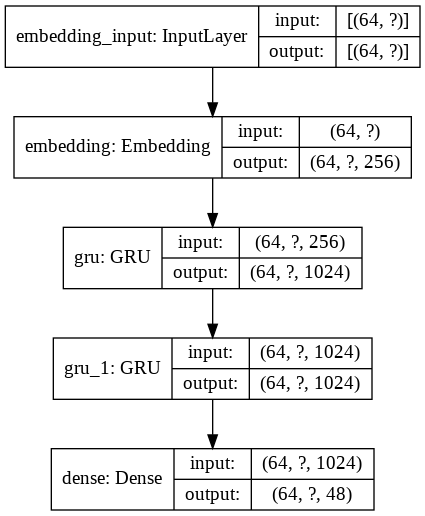

In [13]:
keras.utils.plot_model(gru_model, show_shapes=True, show_layer_names=True, expand_nested=True)

In [0]:
history = gru_model.fit(dataset, epochs=50)

Epoch 1/50
42/42 [==============================] - 110s 3s/step - loss: 11.2932 - accuracy: 0.2322
Epoch 2/50
42/42 [==============================] - 110s 3s/step - loss: 2.4952 - accuracy: 0.3244
Epoch 3/50
42/42 [==============================] - 110s 3s/step - loss: 2.2354 - accuracy: 0.3522
Epoch 4/50
42/42 [==============================] - 111s 3s/step - loss: 2.1602 - accuracy: 0.3667
Epoch 5/50
42/42 [==============================] - 111s 3s/step - loss: 2.1044 - accuracy: 0.3886
Epoch 6/50
42/42 [==============================] - 111s 3s/step - loss: 2.0445 - accuracy: 0.4075
Epoch 7/50
42/42 [==============================] - 111s 3s/step - loss: 1.9892 - accuracy: 0.4274
Epoch 8/50
42/42 [==============================] - 111s 3s/step - loss: 1.9345 - accuracy: 0.4437
Epoch 9/50
42/42 [==============================] - 111s 3s/step - loss: 1.8794 - accuracy: 0.4595
Epoch 10/50
42/42 [==============================] - 111s 3s/step - loss: 1.8411 - accuracy: 0.4716
Epoch 11

In [0]:
main_gru_model = create_model_gru(batch_size=1)
main_gru_model.set_weights(gru_model.get_weights())
main_gru_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (1, None, 256)            12288     
_________________________________________________________________
gru_6 (GRU)                  (1, None, 1024)           3938304   
_________________________________________________________________
gru_7 (GRU)                  (1, None, 1024)           6297600   
_________________________________________________________________
dense_3 (Dense)              (1, None, 48)             49200     
Total params: 10,297,392
Trainable params: 10,297,392
Non-trainable params: 0
_________________________________________________________________


In [0]:
def generate_text(model, start_string, temperature = 1.0):
  num_generate = 1000
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)
  text_generated = []
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      predictions = tf.squeeze(predictions, 0)
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      input_eval = tf.expand_dims([predicted_id], 0)
      text_generated.append(idx2char[predicted_id])
  return (start_string + ''.join(text_generated))

In [0]:
# main_gru_model = tf.keras.models.load_model('char_gru.h5')
# main_gru_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (1, None, 256)            12288     
_________________________________________________________________
gru_6 (GRU)                  (1, None, 1024)           3938304   
_________________________________________________________________
gru_7 (GRU)                  (1, None, 1024)           6297600   
_________________________________________________________________
dense_3 (Dense)              (1, None, 48)             49200     
Total params: 10,297,392
Trainable params: 10,297,392
Non-trainable params: 0
_________________________________________________________________


In [0]:
print(generate_text(main_gru_model, start_string=u"که ایران چوباغیست خرم بهار", temperature=1))

که ایران چوباغیست خرم بهار 	 بکردند درد بنزده نام کرد 
 ده باشد از هامون چنان 	 برو روز بر پیش پیلان گشت 	 به تخت عاج آن روز گشتاسپ 
 یکی نامه‌ای فرمان دید تفت 	 بود آن دست تو شد شب چهر تنگ 
 چنین داد پاسخ که مام خوب کشید 	 ندارد دل کس به فرمان شد سرم 
 که مان ناترست ایران بها 	 وگر خستهٔ نامدار تو 
 از اندر سکندر گونه‌ای نیست هنگ 	 کزو شد نفش دل هیچ پس تست جای 
 نبایش یکدگر شد افسری موبدان 	 به زبه پیمش ببارید شد باز و به چنگ 
 همه جوید از ترک بگریز بخرد 	 بزد گفت بر دست ویران ز راه 
 چو دانش رهنمون جهان را بدین 	 بخواندش پر اندر آید به رزمگه 
 ز هرگون ریختن رای زود خوانش برنش 	 که نبردست تو چاپرست اسفندیار 
 بگویم چنین بیک فرخ جهان 	 از اختر و اندر خمید باش 
 چو از دو دست هرچ هفوا ماند ستوه 	 سخن‌گوی با نوشته شد جای خون 
 چو گریان گفته آمد از گوسفند 	 به یک بیش وپرسد دل نهفت 
 برو تا در صد فرزندمانی 	 شد از اختر نیک ما همه شهریار 
 گیا چون چه دریا بست بار آوریم 	 به شمشیر یک خویش بپشت اسفندیار 
 بدو نام خواهم ز دادش ز بر 	 دلش گشته از کارزار و تخت 
 نزد پس نامه سیاه نیست 	 روانش چون 

In [0]:
main_gru_model.save("char_gru.h5")

# Model (LSTM)

In [0]:
def create_model_lstm(vocab_size=len(vocab), embedding_dim=embedding_dim, rnn_units=rnn_units, batch_size=BATCH_SIZE):
  model = keras.Sequential()
  model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]))
  model.add(tf.keras.layers.LSTM(rnn_units,return_sequences=True,stateful=True,
                              recurrent_initializer='glorot_uniform',
                              recurrent_regularizer=keras.regularizers.l2(0.01)
                              ))
  model.add(tf.keras.layers.LSTM(rnn_units,return_sequences=True,stateful=True,
                              recurrent_initializer='glorot_uniform',
                              recurrent_regularizer=keras.regularizers.l2(0.01)
                              ))
  model.add(tf.keras.layers.Dense(vocab_size))
  
  return model

In [15]:
lstm_model = create_model_lstm()
lstm_model.summary()
lstm_model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (64, None, 256)           12288     
_________________________________________________________________
lstm (LSTM)                  (64, None, 1024)          5246976   
_________________________________________________________________
lstm_1 (LSTM)                (64, None, 1024)          8392704   
_________________________________________________________________
dense_1 (Dense)              (64, None, 48)            49200     
Total params: 13,701,168
Trainable params: 13,701,168
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (64, None, 256)           12288     
____________________

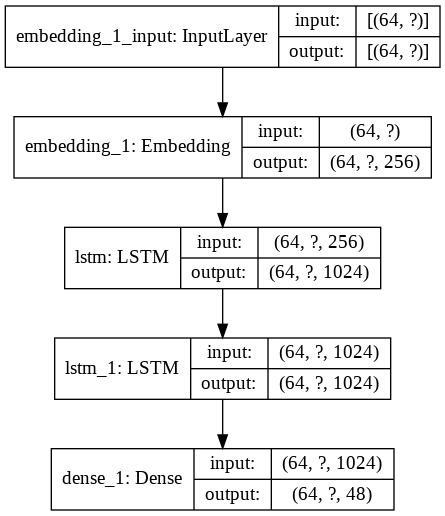

In [16]:
keras.utils.plot_model(lstm_model, show_shapes=True, show_layer_names=True, expand_nested=True)

In [0]:
history = lstm_model.fit(dataset, epochs=50)

Epoch 1/50
42/42 [==============================] - 143s 3s/step - loss: 12.9389 - accuracy: 0.2126
Epoch 2/50
42/42 [==============================] - 145s 3s/step - loss: 3.4909 - accuracy: 0.2674
Epoch 3/50
42/42 [==============================] - 145s 3s/step - loss: 2.6487 - accuracy: 0.3036
Epoch 4/50
42/42 [==============================] - 145s 3s/step - loss: 2.4302 - accuracy: 0.3320
Epoch 5/50
42/42 [==============================] - 145s 3s/step - loss: 2.3159 - accuracy: 0.3452
Epoch 6/50
42/42 [==============================] - 145s 3s/step - loss: 2.2287 - accuracy: 0.3622
Epoch 7/50
42/42 [==============================] - 145s 3s/step - loss: 2.1557 - accuracy: 0.3777
Epoch 8/50
42/42 [==============================] - 144s 3s/step - loss: 2.1006 - accuracy: 0.3915
Epoch 9/50
42/42 [==============================] - 144s 3s/step - loss: 2.0357 - accuracy: 0.4050
Epoch 10/50
42/42 [==============================] - 144s 3s/step - loss: 1.9800 - accuracy: 0.4178
Epoch 11

In [0]:
main_lstm_model = create_model_lstm(batch_size=1)
main_lstm_model.set_weights(lstm_model.get_weights())
main_lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 256)            12288     
_________________________________________________________________
lstm_2 (LSTM)                (1, None, 1024)           5246976   
_________________________________________________________________
lstm_3 (LSTM)                (1, None, 1024)           8392704   
_________________________________________________________________
dense_1 (Dense)              (1, None, 48)             49200     
Total params: 13,701,168
Trainable params: 13,701,168
Non-trainable params: 0
_________________________________________________________________


In [0]:
# main_lstm_model = tf.keras.models.load_model('char_lstm.h5')
# main_lstm_model.summary()

In [0]:
print(generate_text(main_lstm_model, start_string=u"که ایران چوباغیست خرم بهار", temperature=1))

که ایران چوباغیست خرم بهار 	 نهاده بنشست با با ساو بدند 
 ز درین یزدان نیکی تیره‌رون 	 به پوزش همی کرد رخ با سپاه 
 به چیزبان به پیداز او رستم 	 نه پی رخ شد جوید گوی و هوش 
 چو خردان به گردن افراسیاب 	 جز از تو گرد کرد و گردد راه 
 چنین گفت گودرز و خوردی و ماه 	 بدانی که با و توران بر نهاد جای 
 کلیدم نزدیک او برگزین 	 وزان پس خجسته فراوان شنید 
 سوی بادی سرت دستور باش 	 همی تا بادافر و خسرو به جای 
 چو برگشت زن یک لشکر بنده‌ایم 	 برزم و برین خوردن سال هزار 
 بر تخت زرنگ و ننگ نونونیز 	 تو گفتی از نامورش نیک‌بخت 
 وزو گشت لرزبادی مجلد 	 سر برش دل مردم اگراز 
 بدو گفت بر زمان بگویی 	 تو را نیایش کن جز بیشتی 
 اگر برگشته از به بر تخت 	 که در جنا تن دست برد یاد جفت 
 برآمد سرکشان به طیل ژیان 	 ز ترکان هوشی کدادی پدید 
 اگر تیز لشکر بگویی درشت 	 ستاره شد باد لب خفتان جنگ 
 نخفتی ز کهرم چنین تا سرفراز 	 کمربست و بر تن و بناداز 
 بخواند پیرام و جوان جوان 	 ز بسر فرش تابد سر دیوار 
 برفتند خواهی که اندر مخ بشاه 	 کمان تا کس باید باید نگفت 
 همی‌گفت سیاه ده گنجور هیچ گرد 	 شد از پیش اندکیمگان 

In [0]:
main_lstm_model.save("char_lstm.h5")